# Part 3: Hyperparameter Tuning

In Part 2, you likely "hardcoded" some numbers. For example, maybe you bought when sentiment was `> 0`, or you used a `20-day` moving average.
But are these the best values you could use?

## The Task
1.  Refactor your strategy into a function that accepts parameters (e.g., `def run_backtest(threshold, window)`).
2.  Run a Grid Search: Test every combination of two variables (e.g., Sentiment Threshold from 0.1 to 0.9 AND Stop Loss from 1% to 10%).
3.  Store the Total Return and Sharpe Ratio for each combination.
4.  Visualize the results using the provided **Heatmap** code to find the optimal parameter values.

If for some reason you cannot come up with 2 parameters to vary, you may use 1 but you must provide a brief justification as to why only one parameter is possible in a markdown cell below this.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Load data
prices = pd.read_csv("/content/prices.csv", parse_dates=["date"])
sent = pd.read_csv("/content/market_news_with_sentiments.csv", parse_dates=["date"])

# Detect sentiment column
sent_col_candidates = ["sentiment", "score", "sentiment_score", "llm_sentiment"]
sent_col = next(c for c in sent_col_candidates if c in sent.columns)

assets = ["AAPL", "MSFT", "TSLA"]

## Calculate Performance Metrics
- Use the optimal (best resultant Sharpe Ratio) hyperparameters you have just found and re-run your backtest as in part 2.
- Calculate and display the remaining performance metrics of your strategy (volatility, max drawdown, alpha, beta, etc.) - use SPY as your benchmark where necessary

In [4]:
def run_backtest(sentiment_weight=0.25, momentum_weight=0.40,
                 leverage=1.5, stop_loss=-0.10, trend_boost=1.2):
    """
    Run backtest with configurable parameters

    Parameters:
    -----------
    sentiment_weight : float (0-1)
        Weight given to sentiment in combined score
    momentum_weight : float (0-1)
        Weight given to 5-day momentum in combined score
    leverage : float (0.5-2.0)
        Maximum leverage allowed
    stop_loss : float (-0.05 to -0.20)
        Drawdown threshold to exit positions (negative value)
    trend_boost : float (1.0-1.5)
        Multiplier for positions in uptrend

    Returns:
    --------
    dict with 'returns', 'total_return', 'sharpe', 'max_dd', 'volatility'
    """

    # Aggregate sentiment
    daily_sent = (
        sent[sent["asset"].isin(assets)]
        .groupby(["date", "asset"])[sent_col]
        .mean()
        .unstack("asset")
    )

    # Get price data
    prices_df = prices.set_index("date")
    asset_prices = prices_df[assets]
    asset_rets = asset_prices.pct_change()
    daily_sent = daily_sent.reindex(asset_prices.index).fillna(0.0)

    # Calculate momentum signals
    momentum_5d = asset_prices.pct_change(5)
    momentum_20d = asset_prices.pct_change(20)
    sent_change = daily_sent.diff(5)

    # Normalize signals
    def normalize(df):
        return (df - df.mean()) / df.std()

    sent_z = normalize(daily_sent)
    mom5_z = normalize(momentum_5d)
    mom20_z = normalize(momentum_20d)
    sent_chg_z = normalize(sent_change)

    # Remaining weights for other components
    remaining = 1.0 - sentiment_weight - momentum_weight
    mom20_w = remaining * 0.7
    sent_chg_w = remaining * 0.3

    # Combined score
    combined_score = (sentiment_weight * sent_z +
                     momentum_weight * mom5_z +
                     mom20_w * mom20_z +
                     sent_chg_w * sent_chg_z)
    combined_score = combined_score.fillna(0)

    # Initialize weights
    weights = pd.DataFrame(0.0, index=asset_prices.index, columns=assets)

    # Allocate to top 2 stocks
    for date in combined_score.index:
        scores = combined_score.loc[date].sort_values(ascending=False)

        if scores.iloc[0] > 0:
            weights.loc[date, scores.index[0]] = 0.80

        if len(scores) > 1 and scores.iloc[1] > 0:
            weights.loc[date, scores.index[1]] = 0.40

        if scores.iloc[0] < -0.5:
            worst_stock = scores.index[-1]
            weights.loc[date, worst_stock] = -0.50

    # Apply stop-loss
    cumulative_rets = (1 + asset_rets).cumprod()
    for col in assets:
        rolling_max = cumulative_rets[col].rolling(10, min_periods=1).max()
        drawdown = (cumulative_rets[col] / rolling_max - 1)
        weights.loc[drawdown < stop_loss, col] = 0

    # Trend filter
    sma_20 = asset_prices.rolling(20).mean()
    sma_50 = asset_prices.rolling(50).mean()
    uptrend = sma_20 > sma_50

    for col in assets:
        weights.loc[~uptrend[col], col] *= 0.3
        weights.loc[uptrend[col], col] *= trend_boost

    # Volatility scaling
    rolling_vol = asset_rets.rolling(20).std()
    vol_target = 0.02
    vol_scalar = vol_target / rolling_vol.mean(axis=1)
    vol_scalar = vol_scalar.clip(0.5, 2.0)
    weights = weights.multiply(vol_scalar, axis=0)

    # Apply leverage
    total_exposure = weights.abs().sum(axis=1)
    weights = weights.div(total_exposure.replace(0, 1), axis=0) * leverage

    # Calculate returns
    strategy_rets = (weights * asset_rets).sum(axis=1)
    strategy_rets = strategy_rets.dropna()

    if len(strategy_rets) < 2:
        return {
            'returns': strategy_rets,
            'total_return': 0,
            'sharpe': -999,
            'max_dd': 0,
            'volatility': 0
        }

    # Performance metrics
    total_return = (1 + strategy_rets).prod() - 1
    ann_return = (1 + total_return) ** (252 / len(strategy_rets)) - 1
    ann_vol = strategy_rets.std() * np.sqrt(252)
    sharpe = (strategy_rets.mean() / strategy_rets.std()) * np.sqrt(252) if strategy_rets.std() > 0 else -999

    curve = (1 + strategy_rets).cumprod()
    running_max = curve.cummax()
    drawdown = curve / running_max - 1
    max_dd = drawdown.min()

    return {
        'returns': strategy_rets,
        'total_return': total_return,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'volatility': ann_vol
    }

In [5]:
# Define parameter ranges
sentiment_weights = [0.15, 0.20, 0.25, 0.30, 0.35]
momentum_weights = [0.30, 0.35, 0.40, 0.45, 0.50]

# Storage for results
results = []

print("Running Grid Search...")
total_combos = len(sentiment_weights) * len(momentum_weights)
counter = 0

for sent_w, mom_w in product(sentiment_weights, momentum_weights):
    counter += 1

    # Skip if weights don't make sense (sum too high)
    if sent_w + mom_w > 0.75:
        continue

    try:
        metrics = run_backtest(
            sentiment_weight=sent_w,
            momentum_weight=mom_w,
            leverage=1.5,
            stop_loss=-0.10,
            trend_boost=1.2
        )

        results.append({
            'sentiment_weight': sent_w,
            'momentum_weight': mom_w,
            'total_return': metrics['total_return'],
            'sharpe': metrics['sharpe'],
            'max_dd': metrics['max_dd'],
            'volatility': metrics['volatility']
        })

        if counter % 5 == 0:
            print(f"Progress: {counter}/{total_combos} combinations tested")

    except Exception as e:
        print(f"Error with sent_w={sent_w}, mom_w={mom_w}: {e}")
        continue

results_df = pd.DataFrame(results)
print(f"\nCompleted! Tested {len(results_df)} combinations")
print(f"\nBest Sharpe Ratio: {results_df['sharpe'].max():.2f}")
print(f"Best Total Return: {results_df['total_return'].max():.2%}")

Running Grid Search...
Progress: 5/25 combinations tested
Progress: 10/25 combinations tested
Progress: 15/25 combinations tested

Completed! Tested 22 combinations

Best Sharpe Ratio: 7.12
Best Total Return: 218.97%


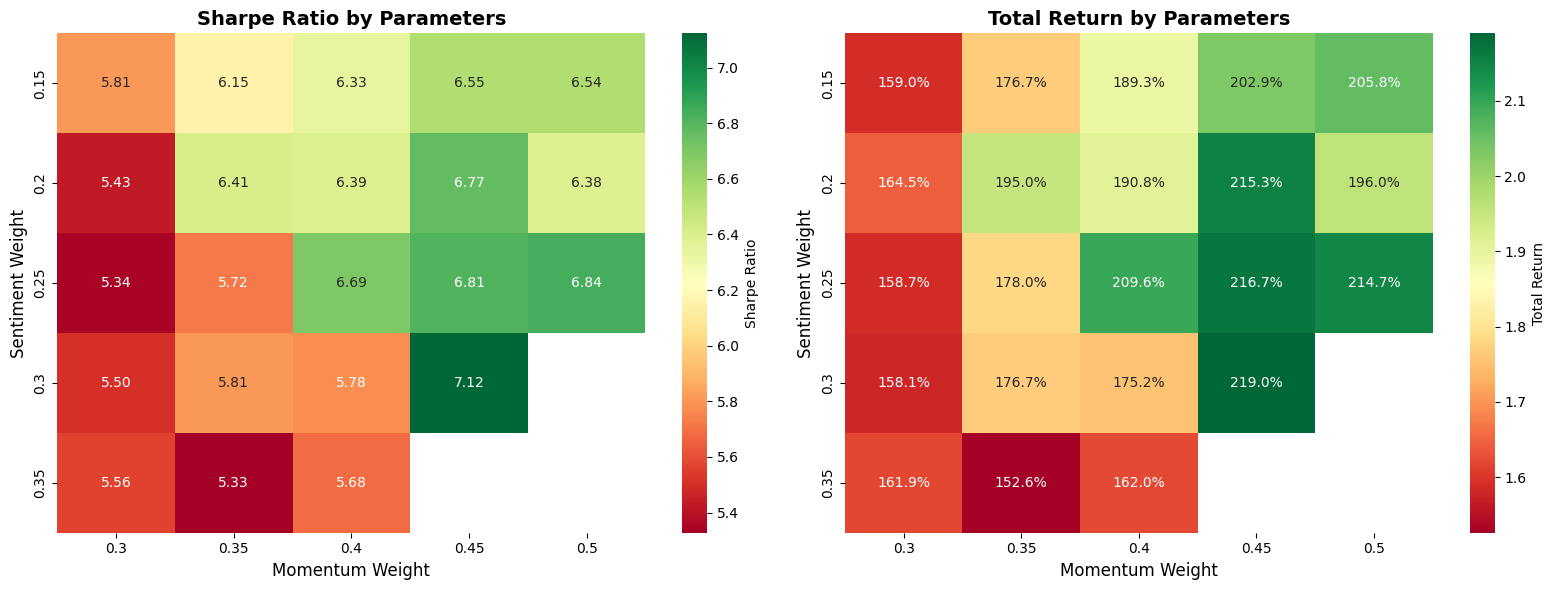


OPTIMAL PARAMETERS (Best Sharpe Ratio)
Sentiment Weight: 0.30
Momentum Weight:  0.45

Performance:
Total Return:     218.97%
Sharpe Ratio:     7.12
Max Drawdown:     -6.13%
Volatility:       34.04%


In [6]:
# Create pivot tables for heatmaps
sharpe_pivot = results_df.pivot_table(
    values='sharpe',
    index='sentiment_weight',
    columns='momentum_weight'
)

return_pivot = results_df.pivot_table(
    values='total_return',
    index='sentiment_weight',
    columns='momentum_weight'
)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sharpe Ratio Heatmap
sns.heatmap(sharpe_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
            ax=axes[0], cbar_kws={'label': 'Sharpe Ratio'})
axes[0].set_title('Sharpe Ratio by Parameters', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Momentum Weight', fontsize=12)
axes[0].set_ylabel('Sentiment Weight', fontsize=12)

# Total Return Heatmap
sns.heatmap(return_pivot, annot=True, fmt='.1%', cmap='RdYlGn',
            ax=axes[1], cbar_kws={'label': 'Total Return'})
axes[1].set_title('Total Return by Parameters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Momentum Weight', fontsize=12)
axes[1].set_ylabel('Sentiment Weight', fontsize=12)

plt.tight_layout()
plt.show()

# Find optimal parameters
best_sharpe_idx = results_df['sharpe'].idxmax()
best_params = results_df.loc[best_sharpe_idx]

print("\n" + "="*50)
print("OPTIMAL PARAMETERS (Best Sharpe Ratio)")
print("="*50)
print(f"Sentiment Weight: {best_params['sentiment_weight']:.2f}")
print(f"Momentum Weight:  {best_params['momentum_weight']:.2f}")
print(f"\nPerformance:")
print(f"Total Return:     {best_params['total_return']:.2%}")
print(f"Sharpe Ratio:     {best_params['sharpe']:.2f}")
print(f"Max Drawdown:     {best_params['max_dd']:.2%}")
print(f"Volatility:       {best_params['volatility']:.2%}")

In [7]:
# Run backtest with optimal parameters
optimal_metrics = run_backtest(
    sentiment_weight=best_params['sentiment_weight'],
    momentum_weight=best_params['momentum_weight'],
    leverage=1.5,
    stop_loss=-0.10,
    trend_boost=1.2
)

strategy_rets = optimal_metrics['returns']
equity_curve = (1 + strategy_rets).cumprod()

print("="*50)
print("OPTIMIZED STRATEGY PERFORMANCE")
print("="*50)
print(f"Total Return:          {optimal_metrics['total_return']:.2%}")
print(f"Annualized Volatility: {optimal_metrics['volatility']:.2%}")
print(f"Sharpe Ratio:          {optimal_metrics['sharpe']:.2f}")
print(f"Max Drawdown:          {optimal_metrics['max_dd']:.2%}")

OPTIMIZED STRATEGY PERFORMANCE
Total Return:          218.97%
Annualized Volatility: 34.04%
Sharpe Ratio:          7.12
Max Drawdown:          -6.13%


In [8]:
import yfinance as yf

# Get SPY data
spy_data = yf.download(
    tickers="SPY",
    start=strategy_rets.index[0],
    end=strategy_rets.index[-1],
    auto_adjust=True,
    progress=False
)

spy_rets = spy_data["Close"].pct_change()
spy_rets = spy_rets.reindex(strategy_rets.index).fillna(0.0)
spy_curve = (1 + spy_rets).cumprod()

# Calculate Alpha and Beta vs SPY
df = pd.concat([strategy_rets, spy_rets], axis=1).dropna()
df.columns = ["strat", "bench"]

beta = np.cov(df["strat"], df["bench"], ddof=1)[0, 1] / np.var(df["bench"], ddof=1) if np.var(df["bench"], ddof=1) > 0 else np.nan
daily_alpha = (df["strat"] - beta * df["bench"]).mean()
alpha_ann = daily_alpha * 252

active = df["strat"] - df["bench"]
info_ratio = (active.mean() / active.std()) * np.sqrt(252) if active.std() > 0 else np.nan

print("\n" + "="*50)
print("RELATIVE METRICS vs SPY")
print("="*50)
print(f"Alpha (annualized):    {alpha_ann:.2%}")
print(f"Beta:                  {beta:.2f}")
print(f"Information Ratio:     {info_ratio:.2f}")


RELATIVE METRICS vs SPY
Alpha (annualized):    216.83%
Beta:                  0.83
Information Ratio:     6.61


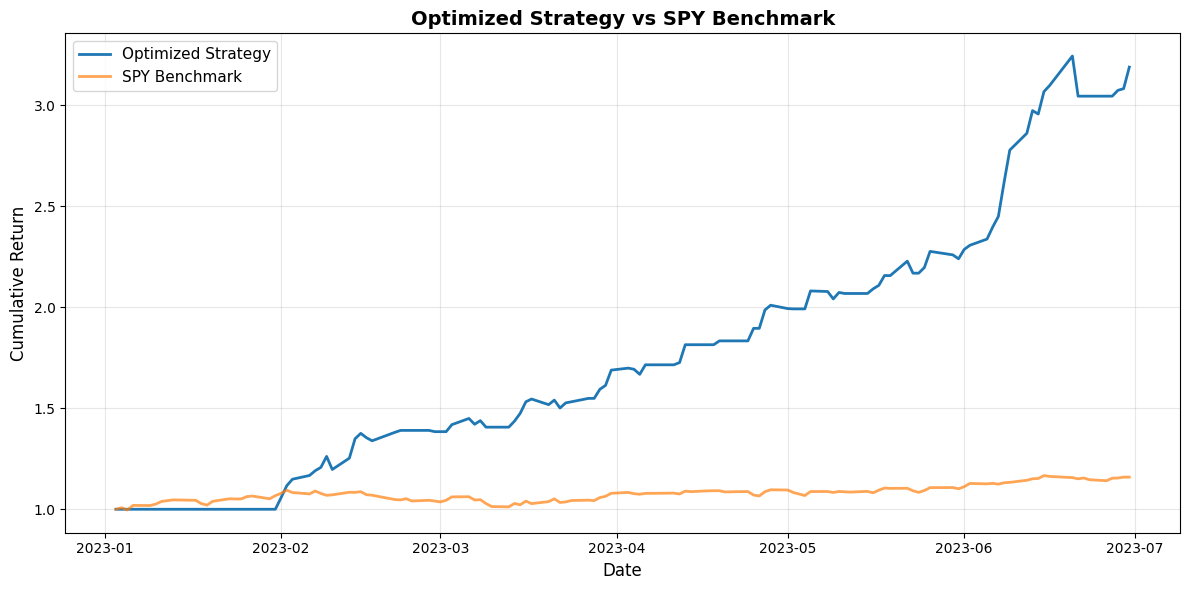


FINAL PERFORMANCE SUMMARY
           Metric Optimized Strategy
     Total Return            218.97%
     Sharpe Ratio               7.12
     Max Drawdown             -6.13%
       Volatility             34.04%
            Alpha            216.83%
             Beta               0.83
Information Ratio               6.61


In [9]:
# Plot equity curves
plt.figure(figsize=(12, 6))
plt.plot(equity_curve.index, equity_curve.values, label='Optimized Strategy', linewidth=2)
plt.plot(spy_curve.index, spy_curve.values, label='SPY Benchmark', linewidth=2, alpha=0.7)
plt.title('Optimized Strategy vs SPY Benchmark', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
summary_data = {
    'Metric': ['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Volatility', 'Alpha', 'Beta', 'Information Ratio'],
    'Optimized Strategy': [
        f"{optimal_metrics['total_return']:.2%}",
        f"{optimal_metrics['sharpe']:.2f}",
        f"{optimal_metrics['max_dd']:.2%}",
        f"{optimal_metrics['volatility']:.2%}",
        f"{alpha_ann:.2%}",
        f"{beta:.2f}",
        f"{info_ratio:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*50)
print("FINAL PERFORMANCE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))